<a href="https://colab.research.google.com/github/MerkulovDaniil/sber21_fmin/blob/sources/notebooks/Neural_Parabola.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Fitting $y = x^2$ with neural network

In [49]:
import torch
from torch.autograd import Variable
import torch.nn.functional as F
import torch.utils.data as Data
import torch.nn as nn

import matplotlib.pyplot as plt
%matplotlib inline

import numpy as np
from tqdm.auto import tqdm

alt_approximation_errors    = []
depths                      = list(range(5,6))
iter_limits                 = [int(30000) for depth in depths]
LR                          = 0.0001
MOMENTUM                    = 0.9
SMOOTHING                   = 0.5
N_STABLE_IT_LIMIT           = 1000
STABLE_REL_TOL              = 1e-5
ITER_TO_CONVERGE            = []
NOISE                       = 0
exp_results                 = {}

x = torch.unsqueeze(torch.linspace(-1, 1, 100), dim=1)  # x data (tensor), shape=(100, 1)
y = x.pow(2) + NOISE*torch.rand(x.size())                 # noisy y data (tensor), shape=(100, 1)

x, y = Variable(x), Variable(y)

class LinearNet(nn.Module):
    def __init__(self, input_size, num_layers, layers_size, output_size):
        super(LinearNet, self).__init__()
        self.linears = nn.ModuleList([nn.Linear(input_size, layers_size)])
        self.linears.extend([nn.Linear(layers_size, layers_size) for i in range(1, num_layers-1)])
        self.linears.append(nn.Linear(layers_size, output_size))
    
    def forward(self, x):
        for layer in self.linears:
            x = layer(x)
        return x

ITER_TO_CONVERGE            = []
alt_approximation_errors    = []
t_ = tqdm(zip(depths, iter_limits))
for depth, iter_limit in t_:
    t_.set_description(f'GD. DEPTH {depth}')
    t_.refresh() # to show immediately the update
    net         = LinearNet(input_size = 1, num_layers = depth, layers_size = 5, output_size = 1)
    rae_old     = torch.norm(net(x) - y)/torch.norm(y)
    n_stable_it = 0
    optimizer   = torch.optim.AdamW(net.parameters(), lr = LR)
    loss_func   = torch.nn.MSELoss() 
    t           = tqdm(range(iter_limit), leave = False)

    for iter in t:
        if iter % 200 == 0:
            t.set_description(f'RAE: {torch.norm(net(x) - y)/torch.norm(y):.3}. STBL {n_stable_it}. LVL {rae_old:.3}')
            t.refresh() # to show immediately the update
        
            prediction = net(x)     
            loss = loss_func(prediction, y)     

            optimizer.zero_grad()  
            loss.backward()        
            optimizer.step()
            
        rae_current  = torch.norm(net(x) - y)/torch.norm(y)
        rae_smoothed = (1-SMOOTHING)*rae_current + SMOOTHING*rae_old

        if (torch.abs(rae_smoothed - rae_old)/rae_old <= STABLE_REL_TOL) and (rae_smoothed < 0.2):
            n_stable_it += 1
        else:
            n_stable_it = 0

        rae_old     = rae_smoothed

        if n_stable_it >= N_STABLE_IT_LIMIT:
            break
        
    ITER_TO_CONVERGE.append(iter)
exp_results['GD']  = {}
exp_results['GD']['iter_convergence']    = ITER_TO_CONVERGE
exp_results['GD']['rae']                 = alt_approximation_errors
exp_results['GD']['depths']              = depths

In [50]:
theta_0_gd = torch.nn.utils.parameters_to_vector(net.parameters())

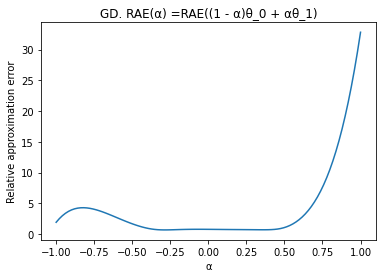

In [51]:
# net = LinearNet(input_size = 1, num_layers = 5, layers_size = 5, output_size = 1)

# theta_0_gd = torch.nn.utils.parameters_to_vector(net.parameters())
theta_1 = theta_0_gd + torch.randn(*theta_0_gd.shape)

alphas = torch.linspace(-1,1)

thetas = [(1 - alpha)*theta_0_gd + alpha*theta_1 for alpha in alphas]
losses = []
for theta in thetas:
    torch.nn.utils.vector_to_parameters(theta, net.parameters())
    losses.append(torch.norm(net(x) - y)/torch.norm(y))

plt.plot(alphas, losses)
plt.title(f'GD. RAE(α) =RAE((1 - α)θ_0 + αθ_1)')
plt.ylabel(f'Relative approximation error')
plt.xlabel(f'α')
plt.show()

In [54]:
# net = LinearNet(input_size = 1, num_layers = 5, layers_size = 5, output_size = 1)

# theta_0_gd = torch.nn.utils.parameters_to_vector(net.parameters())
theta_1 = theta_0_gd + torch.randn(*theta_0_gd.shape)
theta_2 = theta_0_gd + torch.randn(*theta_0_gd.shape)

DRAW_WIDTH = 0.4

alphas = torch.linspace(-DRAW_WIDTH,DRAW_WIDTH)
betas  = torch.linspace(-DRAW_WIDTH,DRAW_WIDTH)
aa, bb = np.meshgrid(alphas, betas)

def new_loss(a,b):
    theta = theta_0_gd + a*theta_1 + b*theta_2
    torch.nn.utils.vector_to_parameters(theta, net.parameters())
    loss_func   = torch.nn.MSELoss() 
    return loss_func(net(x), y)

Z = np.array(aa) 
for i_a, a in enumerate(alphas):
    for i_b, b in enumerate(betas):
        Z[i_a, i_b] = new_loss(a,b)

import plotly.graph_objects as go

import pandas as pd


fig = go.Figure(data=[go.Surface(z=Z)])
fig.update_traces(contours_z=dict(show=True, usecolormap=True,
                                  highlightcolor="limegreen", project_z=True))
fig.update_layout(title='GD training minimum', autosize=False,
                  scene_camera_eye=dict(x=1.87, y=0.88, z=-0.64),
                  width=500, height=500,
                  margin=dict(l=65, r=50, b=65, t=90),
                  scene = dict(xaxis_title='α', yaxis_title='β', zaxis_title = f'RAE(θ0 + (1-α)θ1 + (1-β)θ2)')
)

fig.show()